In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
date = '0504'
name = 'Sansa'
fold = 0
target_variable = 'target_vel'
path_to_models = './Models/Models_Stim_Pos'

In [5]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [6]:
to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)  

## Load pre-processed data

In [7]:
data_path =  './Data/Processed_Data/Tidy_'+name+'_'+date+'.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

In [8]:
baseline_df = tidy_df.loc[tidy_df.type == 'BASELINE'].reset_index()

In [9]:
tonic_df = tidy_df.loc[tidy_df.type == 'TONIC'].reset_index()

In [10]:
stim_df = tidy_df.loc[tidy_df.type == 'BC-REACH'].reset_index()

In [11]:
class CausalTemporalLSTM(nn.Module):
    def __init__(self, num_features=124, 
                    hidden_units= 3, #was 128
                    #initial_offset = -2,
                    num_layers = 2, 
                    input_size = 50,
                    out_dims = 6, 
                    dropout_1 = 0.3, 
                    dropout_2 = 0.3):
        super(CausalTemporalLSTM, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.input_size = input_size

        self.lstm = nn.LSTM(
            input_size= self.num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers= num_layers,
            bidirectional=False,)
            
        #self.linear1 = nn.Linear(in_features=self.num_features, out_features= self.input_size)
        self.linear2 = nn.Linear(in_features=self.hidden_units, out_features=out_dims)


        self.dropout1 = nn.Dropout(p= dropout_1) #trial.suggest_float('dropout_1', 0.1, 0.9)
        self.dropout2 = nn.Dropout(p= dropout_2) 

    def forward(self, x):

        #x = self.linear1(x)
        #x = self.dropout1(x)
        x, _ = self.lstm(x)
        x = self.dropout2(x)
        output = self.linear2(x)
        # Apply sigmoid activation function
        #output = torch.sigmoid(output) # (torch.sigmoid(output) *600 ) - 200
        
        return output.squeeze()

## Get train-val-test split

In [12]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, \
        info_val_base, info_test_base, list_mins_base,\
              list_maxs_base= get_dataset(baseline_df, fold,target_variable=target_variable,no_outliers = False)

Train trials 18
Test trials  6
Val trials 5
We are testing the optimization method on fold  0


In [13]:
xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim,\
      xx_test_stim, yy_test_stim, info_train_stim,\
          info_val_stim, info_test_stim,  list_mins_stim,\
              list_maxs_stim = get_dataset(tonic_df, fold,target_variable=target_variable,  no_outliers = False)

Train trials 22
Test trials  7
Val trials 6
We are testing the optimization method on fold  0


In [14]:
xx_train_all, yy_train_all, xx_val_all, yy_val_all,\
      xx_test_all, yy_test_all, info_train_all, info_val_all,\
          info_test_all,  list_mins_all, \
            list_maxs_all = get_dataset(tidy_df,fold,target_variable=target_variable, no_outliers = False)

Train trials 85
Test trials  27
Val trials 21
We are testing the optimization method on fold  0


In [15]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
#device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32

# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

In [16]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

## Baseline Model

In [17]:
# Add Gaussian noise to input features
xx_train_base = torch.tensor(xx_train_base, dtype=torch.float32) + torch.tensor(np.random.normal(loc=0, scale=0.075, size=xx_train_base.shape), dtype=torch.float32)

In [113]:
''' Hyper Baseline'''

# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5

l1_ratio_reg = 0.5

lr = 0.00005# 0.0002
loss_function = huber_loss
huber_delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
n_hidden_units = 300
num_layers = 2
input_size_LSTM = 120
dropout_1 = 0.2
dropout_2 = 0.4

#Other training hyperparameters

lr_gamma= 0.9 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 15
batch_size_val = 15

In [114]:
# Fit the LSTM model
model_base = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= n_hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size_LSTM,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)

model_base.apply(weight_reset)

CausalTemporalLSTM(
  (lstm): LSTM(128, 300, num_layers=2, batch_first=True)
  (linear2): Linear(in_features=300, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.4, inplace=False)
)

In [115]:
def Regularizer_LSTM(model, alpha=1e-5, l1_ratio=0.5):
    """
    Implement an L1-L2 penalty on the norm of the model weights.

    model: CausalTemporalLSTM instance
    alpha: scaling parameter for the regularization.
    l1_ratio: mixing parameter between L1 and L2 loss.

    Returns:
    reg: regularization term
    """
    w_t = model.lstm.weight_ih_l0
    w_l_1 = model.linear2.weight
   

    l1_loss = w_t.abs().sum() + w_l_1.abs().sum()
    l2_loss = w_t.pow(2.0).sum() + w_l_1.pow(2.0).sum() 

    reg = l1_ratio * l1_loss + (1 - l1_ratio) * l2_loss

    reg = alpha * reg

    return reg


In [116]:
train_losses, val_losses = \
    train_model(model_base, xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)


/home/nerea/CL_UpperLimb_Control/src/trainer.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


Epoch 000 Train 3.7667 Val 2.1985
Epoch 001 Train 3.2223 Val 1.9071
Epoch 002 Train 3.0223 Val 1.8121
Epoch 003 Train 2.8952 Val 1.7422
Epoch 004 Train 2.7735 Val 1.6984
Epoch 005 Train 2.6715 Val 1.6093
Epoch 006 Train 2.5773 Val 1.5878
Epoch 007 Train 2.4868 Val 1.5275
Epoch 008 Train 2.3946 Val 1.5196
Epoch 009 Train 2.3365 Val 1.4878
Epoch 010 Train 2.3011 Val 1.4799
Epoch 011 Train 2.2362 Val 1.4911
Epoch 012 Train 2.2034 Val 1.5113
Epoch 013 Train 2.1660 Val 1.5217
Epoch 014 Train 2.1459 Val 1.5387
Epoch 015 Train 2.1178 Val 1.4663
Epoch 016 Train 2.0968 Val 1.4686
Epoch 017 Train 2.0645 Val 1.4361
Epoch 018 Train 2.0534 Val 1.4338
Epoch 019 Train 2.0339 Val 1.4766
Epoch 020 Train 2.0096 Val 1.4799
Epoch 021 Train 1.9976 Val 1.4961
Epoch 022 Train 1.9861 Val 1.5262
Decrease LR
Epoch 023 Train 1.9780 Val 1.4909
Epoch 024 Train 1.9523 Val 1.5419
Epoch 025 Train 1.9471 Val 1.5212
Epoch 026 Train 1.9370 Val 1.5239
Epoch 027 Train 1.9279 Val 1.5654
Decrease LR
18


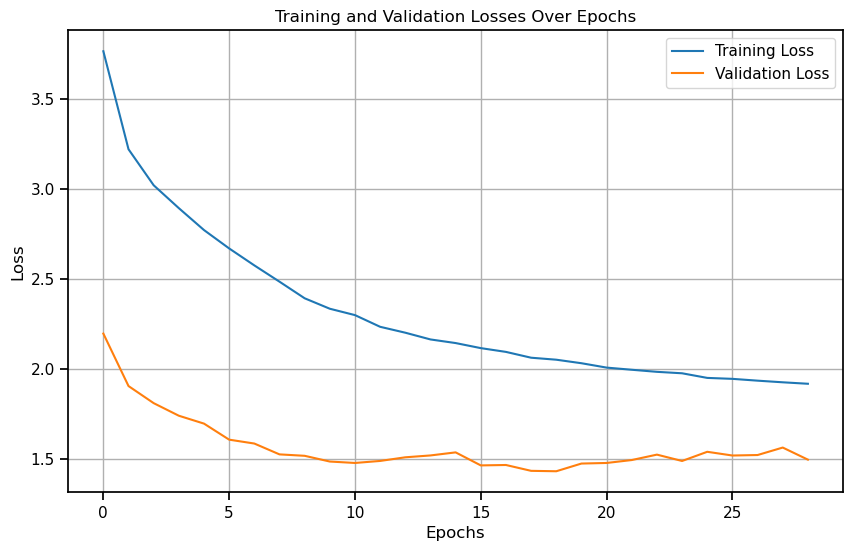

In [117]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [118]:
experiment_name = 'LSTM_2018_'+ name+ '_'+date+'_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_base, path_to_save_model_fold)
# dict_loss = {}
# dict_loss['train'] = train_losses
# dict_loss['val'] = val_losses
# path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
# with open(path_to_save_model_losses, 'wb') as handle:
#     pickle.dump(dict_loss, handle, protocol=4)

In [119]:
model_baselineonly = torch.load(path_to_save_model_fold)
model_baselineonly.eval()

CausalTemporalLSTM(
  (lstm): LSTM(128, 300, num_layers=2, batch_first=True)
  (linear2): Linear(in_features=300, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.4, inplace=False)
)

In [120]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_baselineonly, metric = 'ev')

Train EV: 0.39 
Val EV: 0.33 
Test EV: 0.33 


/home/nerea/CL_UpperLimb_Control/src/trainer.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


In [121]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_baselineonly, metric = 'r2')

Train R2: 0.39 
Val R2: 0.33 
Test R2: 0.33 


/home/nerea/CL_UpperLimb_Control/src/trainer.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


In [122]:
y_true_train, y_pred_train = reshape_to_eval(xx_train_base,yy_train_base, model_baselineonly)

/home/nerea/CL_UpperLimb_Control/src/trainer.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


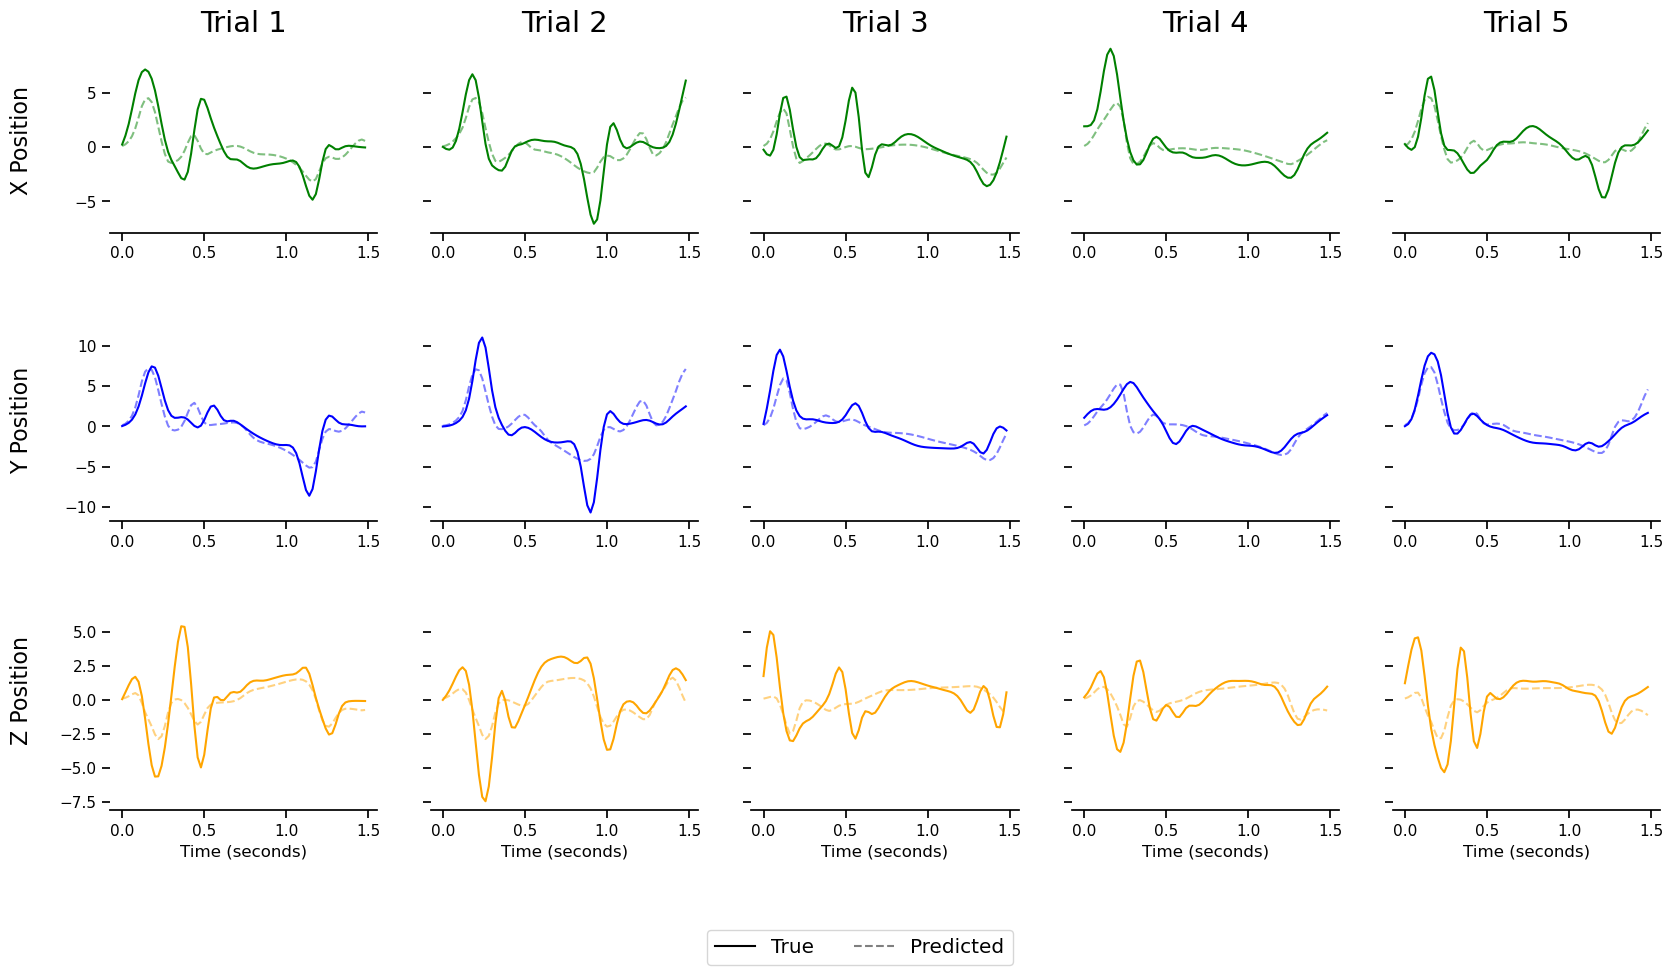

In [123]:
visualize_LSTM_test(y_pred_train, y_true_train, seq_length = 75)

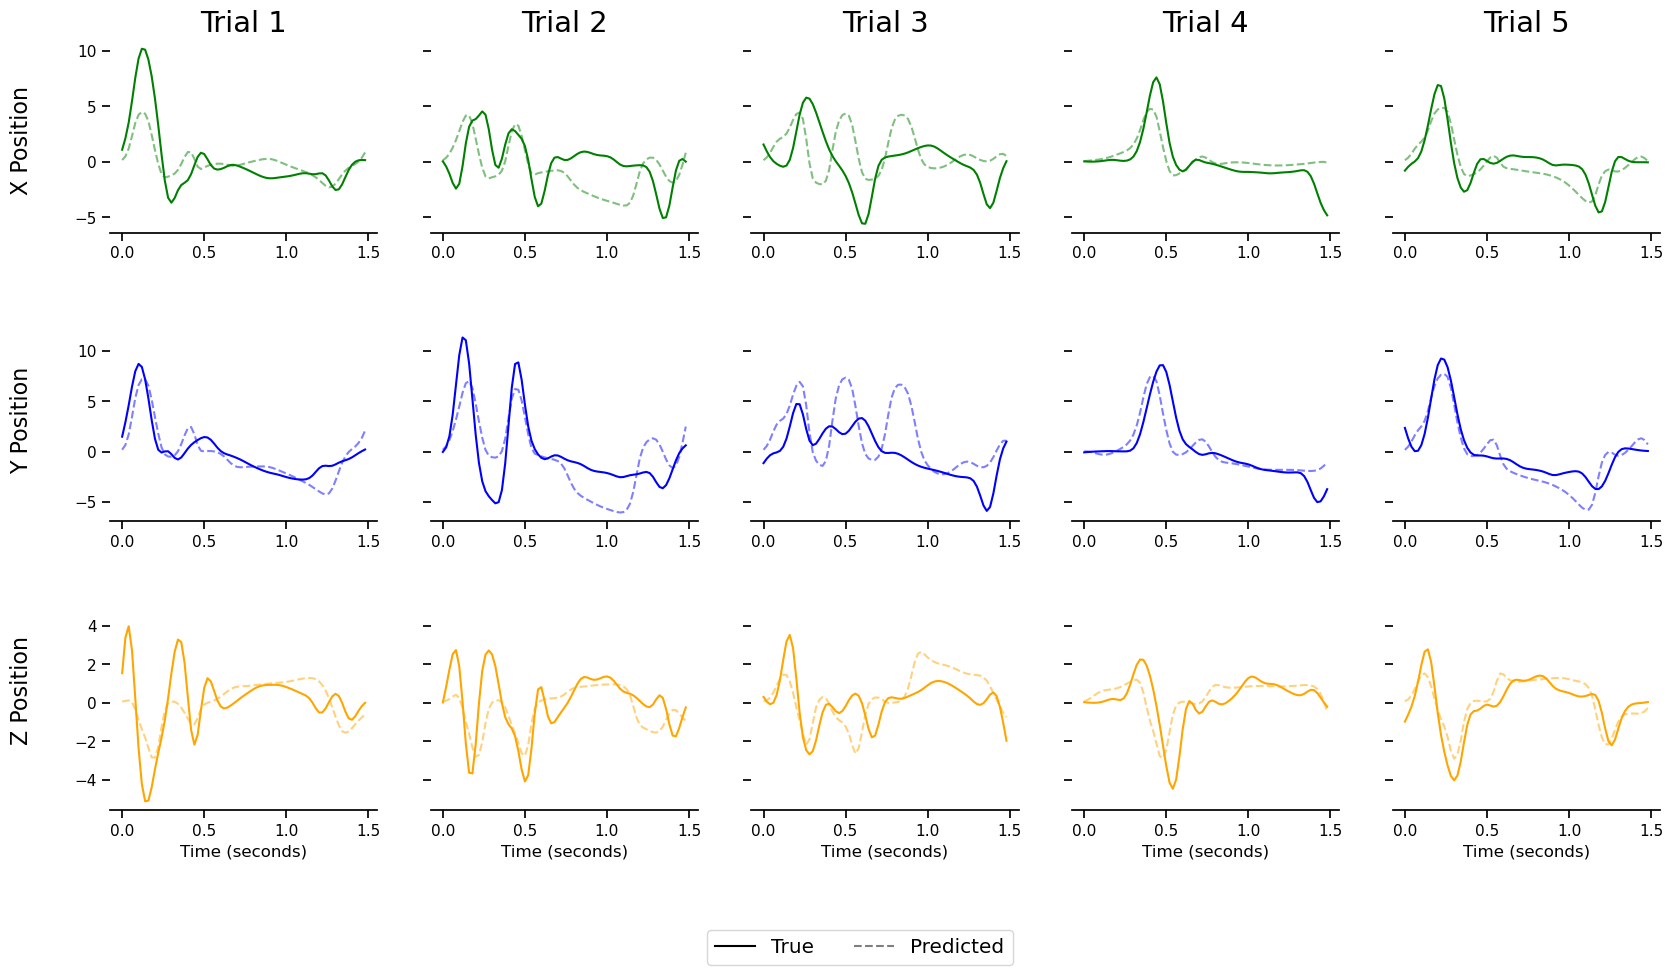

In [124]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Testing the model on stimulation data

In [70]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_baselineonly, metric = 'ev')

Train EV: -0.04 
Val EV: -0.04 
Test EV: -0.05 


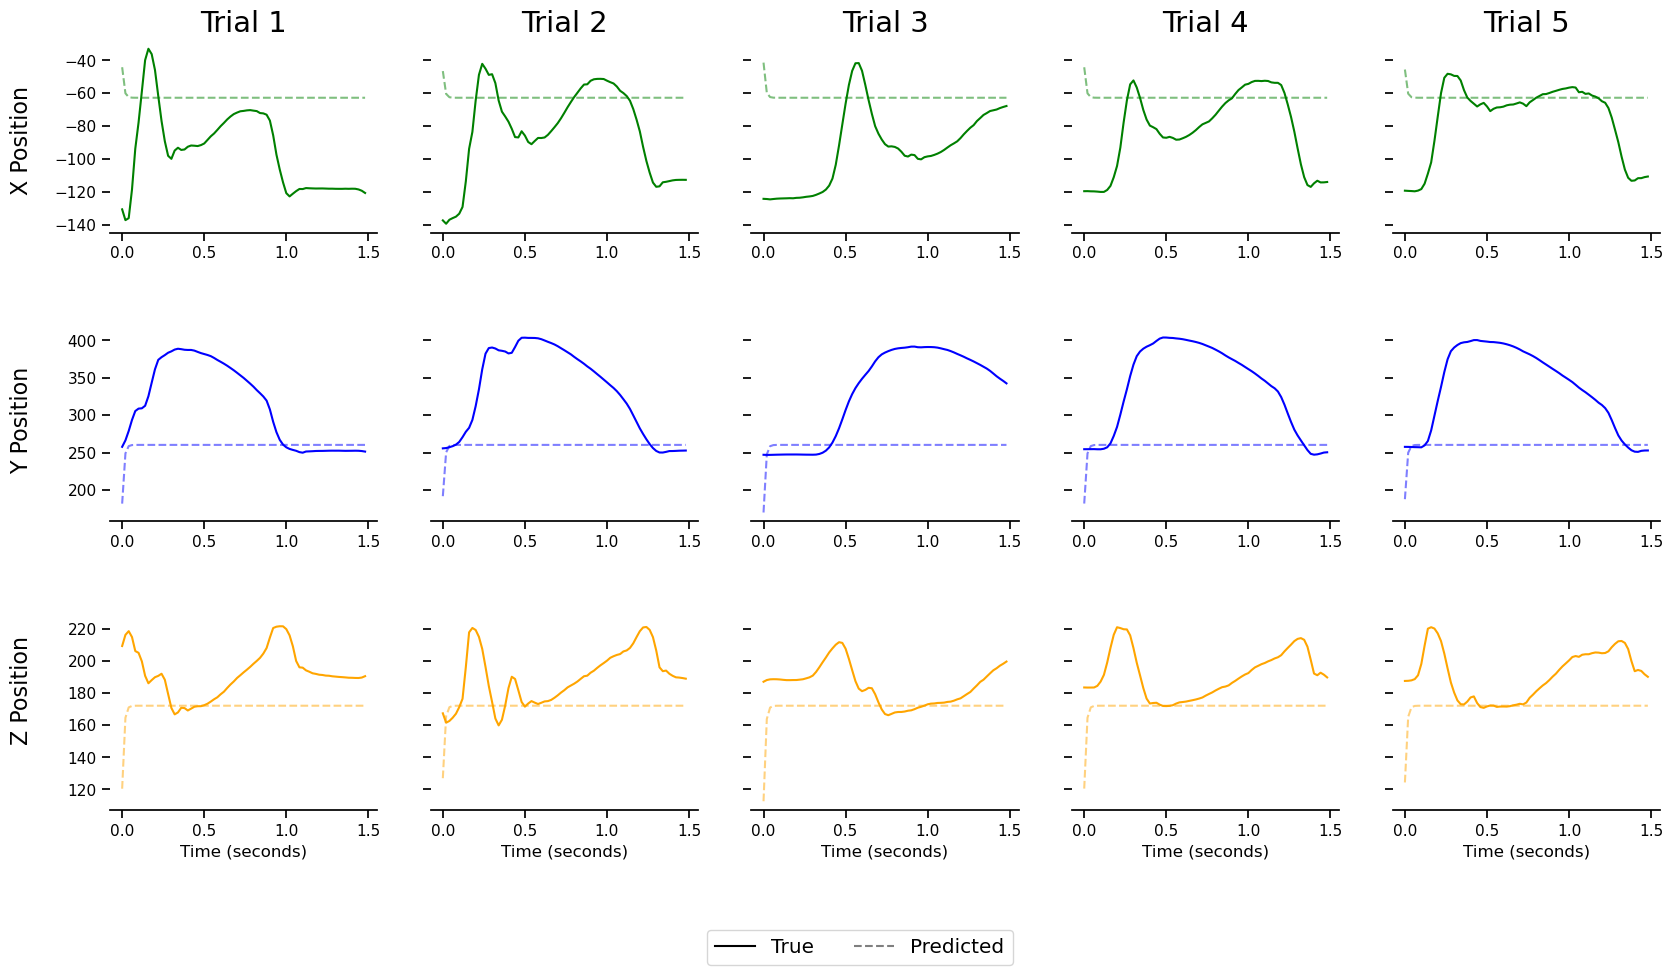

In [71]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Now we use all data for training

In [ ]:
# Fit the LSTM model
model_all = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= n_hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size_LSTM,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)

model_all.apply(weight_reset)

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
train_losses, val_losses = \
    train_model(model_all, xx_train_all,yy_train_all,
                xx_val_all, 
                yy_val_all,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )


Epoch 000 Train 0.0283 Val 0.0127
Epoch 001 Train 0.0119 Val 0.0083
Epoch 002 Train 0.0092 Val 0.0060
Epoch 003 Train 0.0074 Val 0.0044
Epoch 004 Train 0.0062 Val 0.0034
Epoch 005 Train 0.0054 Val 0.0028
Epoch 006 Train 0.0048 Val 0.0026
Epoch 007 Train 0.0043 Val 0.0025
Epoch 008 Train 0.0039 Val 0.0024
Epoch 009 Train 0.0036 Val 0.0023
Epoch 010 Train 0.0034 Val 0.0022
Epoch 011 Train 0.0032 Val 0.0020
Epoch 012 Train 0.0031 Val 0.0019
Epoch 013 Train 0.0029 Val 0.0021
Epoch 014 Train 0.0028 Val 0.0021
Epoch 015 Train 0.0026 Val 0.0020
Epoch 016 Train 0.0024 Val 0.0022
Decrease LR
Epoch 017 Train 0.0023 Val 0.0024
Epoch 018 Train 0.0022 Val 0.0022
Epoch 019 Train 0.0021 Val 0.0021
Epoch 020 Train 0.0021 Val 0.0021
Epoch 021 Train 0.0021 Val 0.0022
Decrease LR
12


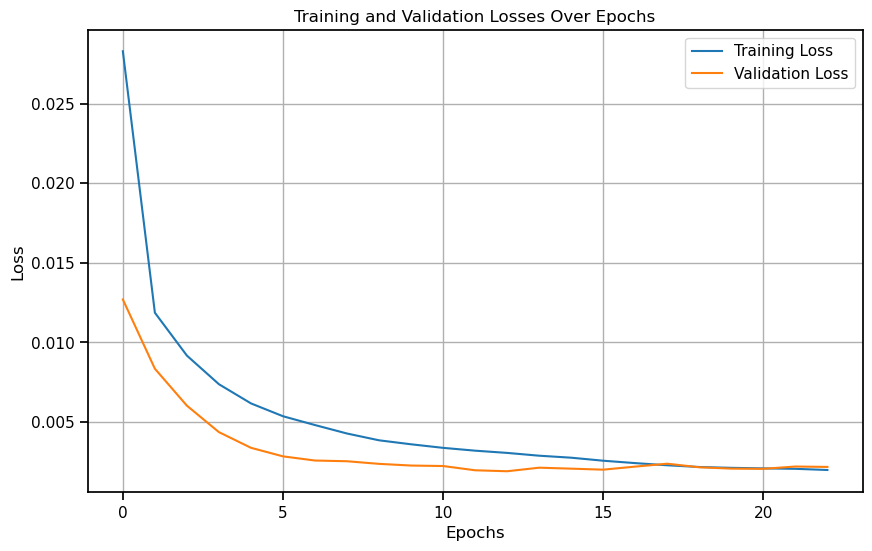

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:

experiment_name = 'LSTM_2018_'+name+'_'+date+'_Alldata'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_all, path_to_save_model_fold)
# dict_loss = {}
# dict_loss['train'] = train_losses
# dict_loss['val'] = val_losses
# path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
# with open(path_to_save_model_losses, 'wb') as handle:
#     pickle.dump(dict_loss, handle, protocol=4)

In [ ]:
model_all_data = torch.load(path_to_save_model_fold)
model_all_data.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_all, yy_train_all, xx_val_all, yy_val_all, xx_test_all, yy_test_all, model_all_data, metric = 'ev')

Train EV: 0.66 
Val EV: 0.65 
Test EV: 0.44 


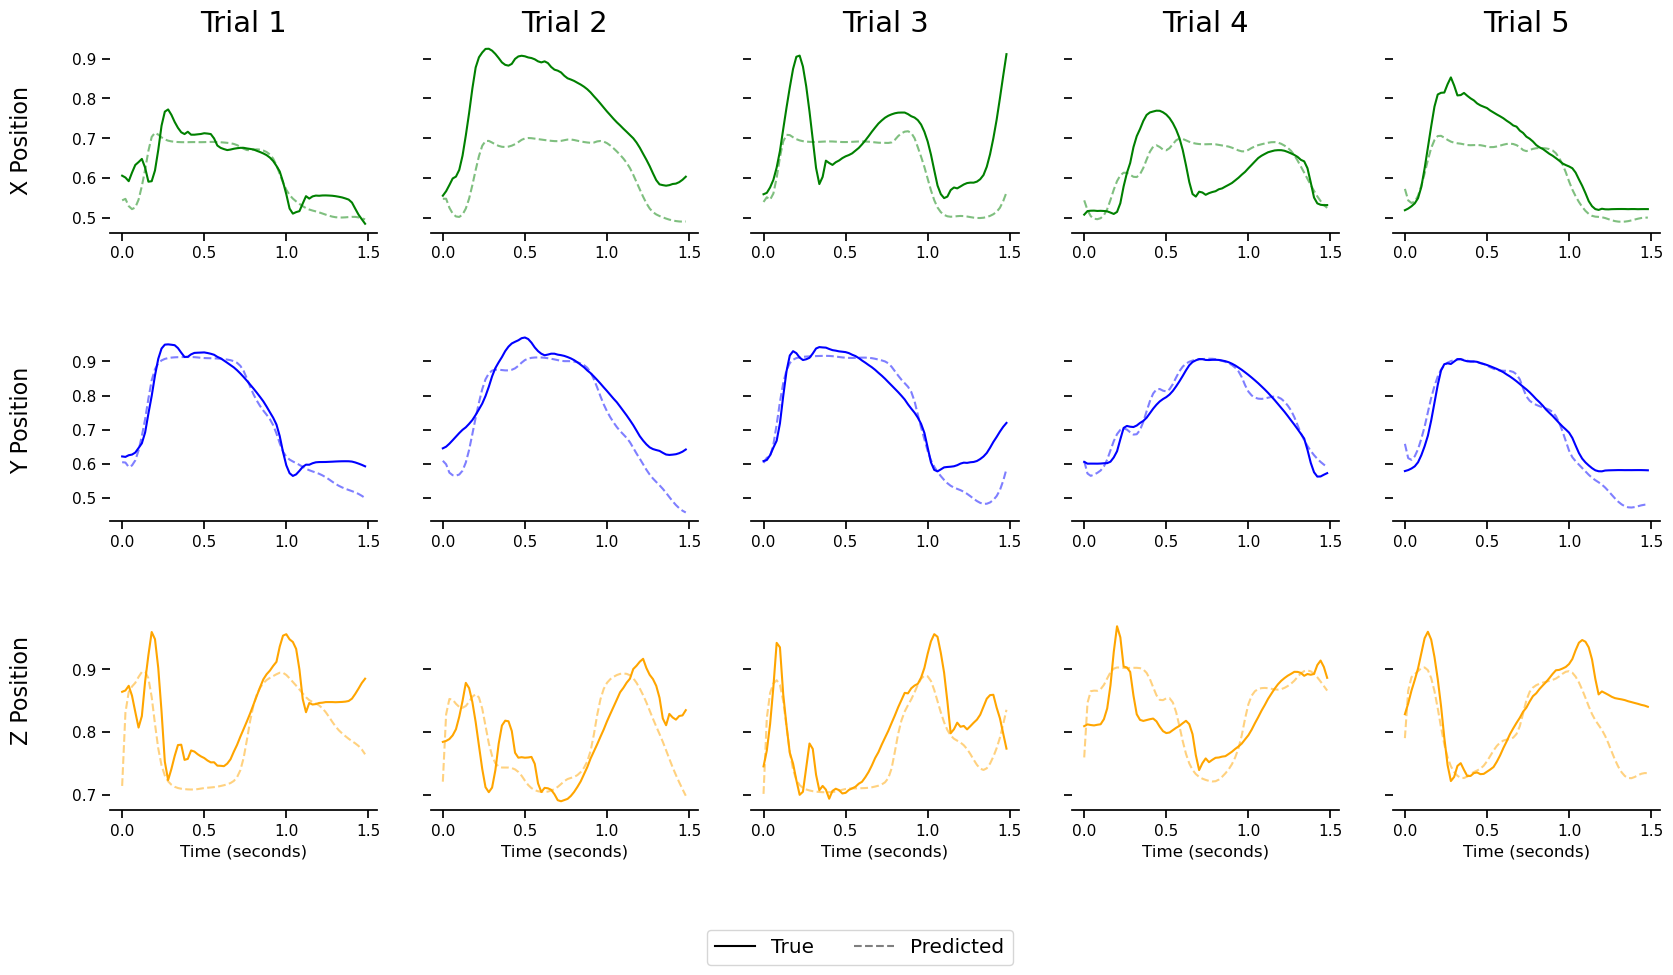

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Implementing EWC

In [ ]:
def get_ewc_loss(model, fisher, p_old):
    loss = 0
    for n, p in model.named_parameters():
        _loss = fisher[n] * (p - p_old[n]) ** 2
        loss += _loss.sum()
    return loss

In [ ]:
x = to_t_eval(xx_train_base) 
y = to_t_eval(yy_train_base)

/tmp/ipykernel_232689/2062473542.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)


In [ ]:
# Assuming X_train and y_train are NumPy arrays or PyTorch tensors
dataset = list(zip(x, y))

In [ ]:
import copy

In [ ]:
model_pre_EWC = copy.deepcopy(model_baselineonly) 
# Flatten the parameters of the copied model
for module in model_pre_EWC.modules():
    if isinstance(module, nn.RNNBase):
        module.flatten_parameters()
model_pre_EWC.train()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
params = {n: p for n, p in model_pre_EWC.named_parameters() if p.requires_grad}
p_old = {}

for n, p in deepcopy(params).items():
    p_old[n] = p.data

In [ ]:
def get_fisher_diag(model, dataset, params, empirical=True):
 
    fisher = {}
    for n, p in deepcopy(params).items():
        p.data.zero_()
        fisher[n] = p.data

    
    for input, gt_label in dataset:
        model.zero_grad()
        output = model(input).view(-1)
        if empirical:
            label = gt_label.view(-1)
            
        else:
            label = output.max(1)[1].view(-1)
            

        h_loss  = huber_loss(output, label)
        #negloglikelihood = F.nll_loss(F.log_softmax(output, dim = -1), label)
        #negloglikelihood.backward()
        model.train()
        h_loss.backward()

        for n, p in model.named_parameters():
            fisher[n].data += p.grad.data ** 2 / len(dataset)

    fisher = {n: p for n, p in fisher.items()}
    return fisher

In [ ]:
fisher_matrix = get_fisher_diag(model_pre_EWC, dataset, params)

In [ ]:
def train_model_EWC(model, X,Y,
                X_val, 
                Y_val,
                lr=lr, # 0.0001,
                lr_step_size= lr_step_size ,#10,
                lr_gamma=lr_gamma,#0.9,
                sequence_length_LSTM= seq_length_LSTM, #10,
                batch_size_train = batch_size_train, #3,
                batch_size_val = batch_size_val,# 3,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None,
                l1_ratio = l1_ratio_reg, #0.5,
                alpha = alpha_reg, #1e-5,     
                early_stop = 5,
                lambda_ewc = 0.2):

    # Set up the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    
        
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset = SequenceDataset(
    Y,    X,    sequence_length=sequence_length_LSTM)

    val_dataset = SequenceDataset(
    Y_val,    X_val,    sequence_length=sequence_length_LSTM)
    loader_train = data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    loader_val = data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loader = loader_train
            else:
                model.eval()
                loader = loader_val

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for X_, y_ in loader:
                X_ = X_.to(device)
                y_ = y_.to(device)
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        output_t = model(X_)
                        output_t = torch.squeeze(output_t)


                        loss_t = huber_loss(output_t, y_, delta = delta)
                        
                        
                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            ewc_loss = get_ewc_loss(model, fisher_matrix, p_old)
                            loss_t += lambda_ewc * ewc_loss
                        #     loss += regularizer(model, l1_ratio, alpha)
                        # Compute gradients and perform an optimization step
                        loss_t.backward(retain_graph=True)
                        optimizer.step()
                else:
                    # just compute the loss in validation phase
                    output_t = model(X_)
                    output_t = torch.squeeze(output_t)

                    loss_t = huber_loss(output_t, y_, delta = delta)
                    

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_epoch = epoch
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses), best_epoch

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses), best_epoch

In [ ]:
train_losses, val_losses, best_epoch = \
    train_model_EWC(model_pre_EWC, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= True,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                lambda_ewc = 1900
                )


Epoch 000 Train 0.0219 Val 0.0175
Epoch 001 Train 0.0163 Val 0.0138
Epoch 002 Train 0.0135 Val 0.0120
Epoch 003 Train 0.0121 Val 0.0110
Epoch 004 Train 0.0112 Val 0.0103
Epoch 005 Train 0.0105 Val 0.0099
Epoch 006 Train 0.0099 Val 0.0096
Epoch 007 Train 0.0095 Val 0.0094
Epoch 008 Train 0.0091 Val 0.0092
Epoch 009 Train 0.0088 Val 0.0091
Epoch 010 Train 0.0085 Val 0.0091
Epoch 011 Train 0.0082 Val 0.0089
Epoch 012 Train 0.0079 Val 0.0088
Epoch 013 Train 0.0077 Val 0.0087
Epoch 014 Train 0.0075 Val 0.0087
Epoch 015 Train 0.0073 Val 0.0086
Epoch 016 Train 0.0071 Val 0.0086
Epoch 017 Train 0.0070 Val 0.0085
Epoch 018 Train 0.0068 Val 0.0084
Epoch 019 Train 0.0067 Val 0.0083
Epoch 020 Train 0.0066 Val 0.0083
Epoch 021 Train 0.0065 Val 0.0083
Epoch 022 Train 0.0063 Val 0.0082
Epoch 023 Train 0.0063 Val 0.0082
Epoch 024 Train 0.0062 Val 0.0081
Epoch 025 Train 0.0061 Val 0.0081
Epoch 026 Train 0.0060 Val 0.0080
Epoch 027 Train 0.0059 Val 0.0079
Epoch 028 Train 0.0058 Val 0.0080
Epoch 029 Trai

In [ ]:
""" import numpy as np

# Define the range of lambda_ewc values for the grid search
#lambda_values = [0.1, 1, 10, 100, 1000, 10000, 100000]  # From here 1000
#lambda_values = [500, 700, 900, 1100, 1300] # from here 900
lambda_values = [1022, 1025, 1027, 1030]

# Initialize lists to store results
lambda_results = []
train_losses_list = []
val_losses_list = []

# Perform grid search
for lambda_ewc in lambda_values:
    model_baselineonly = copy.deepcopy(model_base)
    model_baselineonly.train()
    print('Training model with lambda = ', lambda_ewc)
    # Train the model with current lambda_ewc value
    train_losses, val_losses, best_epoch = train_model_EWC(
        model_baselineonly,
        xx_train_stim,
        yy_train_stim,
        xx_val_stim,
        yy_val_stim,
        lr=lr,
        lr_step_size=lr_step_size,
        lr_gamma=lr_gamma,
        sequence_length_LSTM=seq_length_LSTM,
        batch_size_train=batch_size_train,
        batch_size_val=batch_size_val,
        num_epochs=1000,
        delta=huber_delta,
        regularizer=True,
        l1_ratio=0.5,
        alpha=1e-5,
        early_stop=5,
        lambda_ewc=lambda_ewc
    )
    print('Validation loss ',val_losses[best_epoch])
    # Save the results
    lambda_results.append(lambda_ewc)
    train_losses_list.append(train_losses[best_epoch])  # Final training loss
    val_losses_list.append(val_losses[best_epoch])  # Final validation loss """



Training model with lambda =  1022
Decrease LR
Decrease LR
Validation loss  0.006578730651713086
Training model with lambda =  1025
Decrease LR
Decrease LR
Validation loss  0.00651084865020724
Training model with lambda =  1027
Decrease LR
Decrease LR
Validation loss  0.006460290668660091
Training model with lambda =  1030
Decrease LR
Decrease LR
Validation loss  0.006543198827388538


In [ ]:
# # Print or save the results as needed
# for lambda_val, train_loss, val_loss in zip(lambda_results, train_losses_list, val_losses_list):
#     print(f"Lambda EWC: {lambda_val}, Training Loss: {train_loss}, Validation Loss: {val_loss}")


Lambda EWC: 1022, Training Loss: 0.003058342590390489, Validation Loss: 0.006560251810059713
Lambda EWC: 1025, Training Loss: 0.0025132020363281935, Validation Loss: 0.0064995479513433345
Lambda EWC: 1027, Training Loss: 0.0022583515938606733, Validation Loss: 0.006349790359967324
Lambda EWC: 1030, Training Loss: 0.0020426700412240536, Validation Loss: 0.006414250913562552


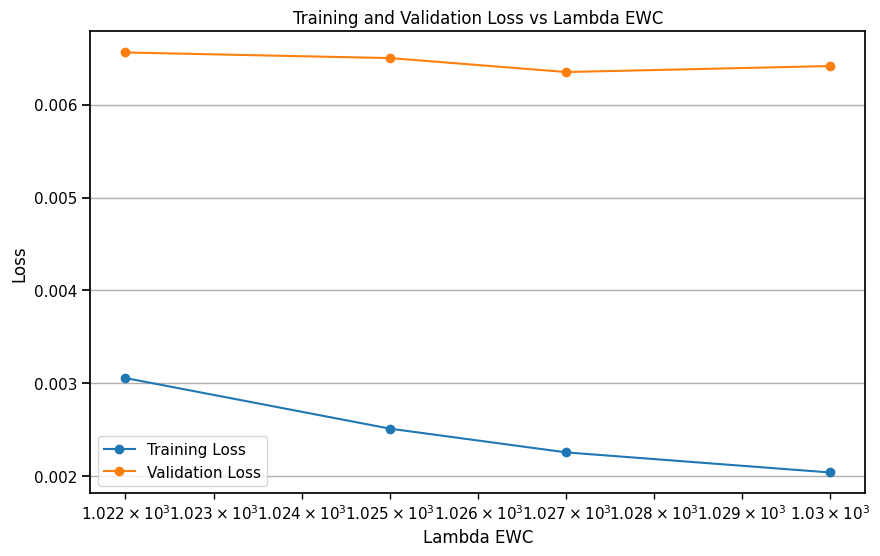

In [ ]:
# import matplotlib.pyplot as plt

# # Plot the graph
# plt.figure(figsize=(10, 6))
# plt.plot(lambda_results, train_losses_list, label='Training Loss', marker='o')
# plt.plot(lambda_results, val_losses_list, label='Validation Loss', marker='o')
# plt.xscale('log')  # Set logarithmic scale for lambda values
# plt.xlabel('Lambda EWC')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss vs Lambda EWC')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
#best_lambda = lambda_results[np.argmin(val_losses_list)]

In [ ]:
experiment_name = 'LSTM_2018_'+name+'_'+date+'_EWC'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_pre_EWC, path_to_save_model_fold)
# dict_loss = {}
# dict_loss['train'] = train_losses
# dict_loss['val'] = val_losses
# path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
# with open(path_to_save_model_losses, 'wb') as handle:
#     pickle.dump(dict_loss, handle, protocol=4)

In [ ]:
model_EWC = torch.load(path_to_save_model_fold)
model_EWC.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

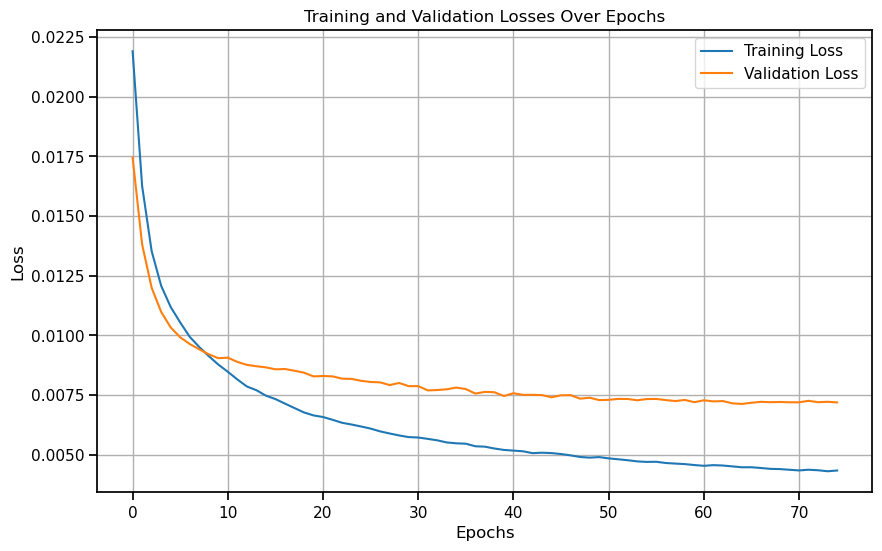

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_EWC, metric = 'ev')

Train EV: 0.84 
Val EV: 0.64 
Test EV: 0.72 


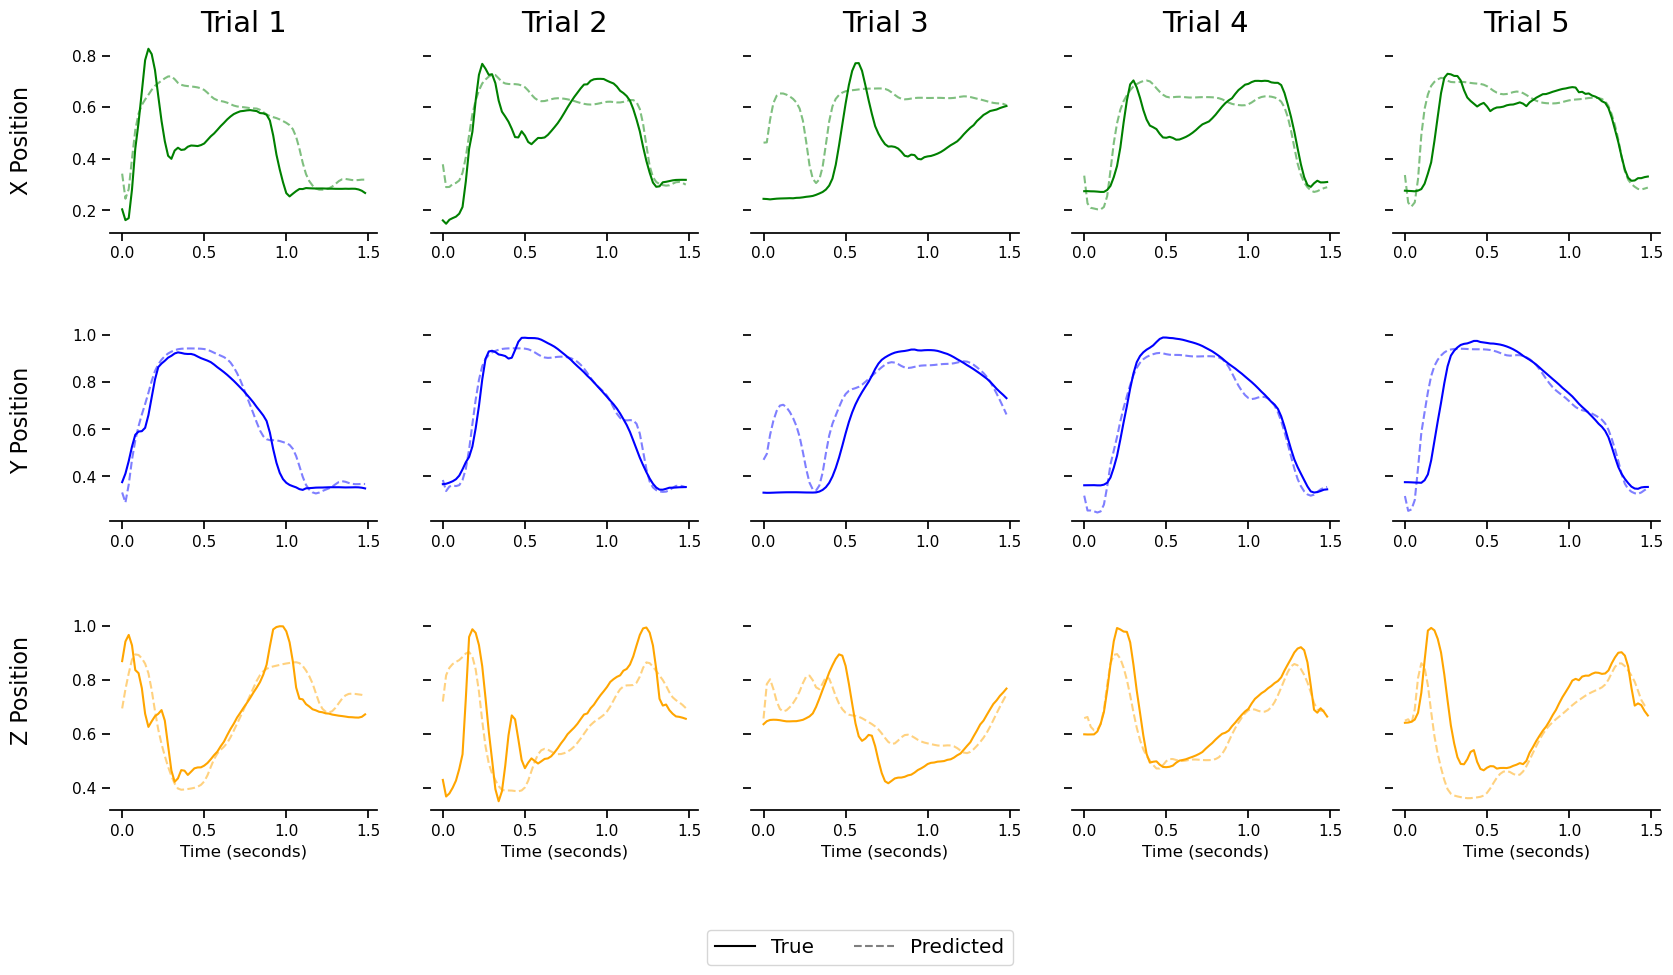

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

### Testing the performance of the model on Baseline data after EWC

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_EWC, metric = 'ev')

Train EV: -0.08 
Val EV: -0.49 
Test EV: -0.20 


/home/nerea/CL_UpperLimb_Control/src/trainer.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


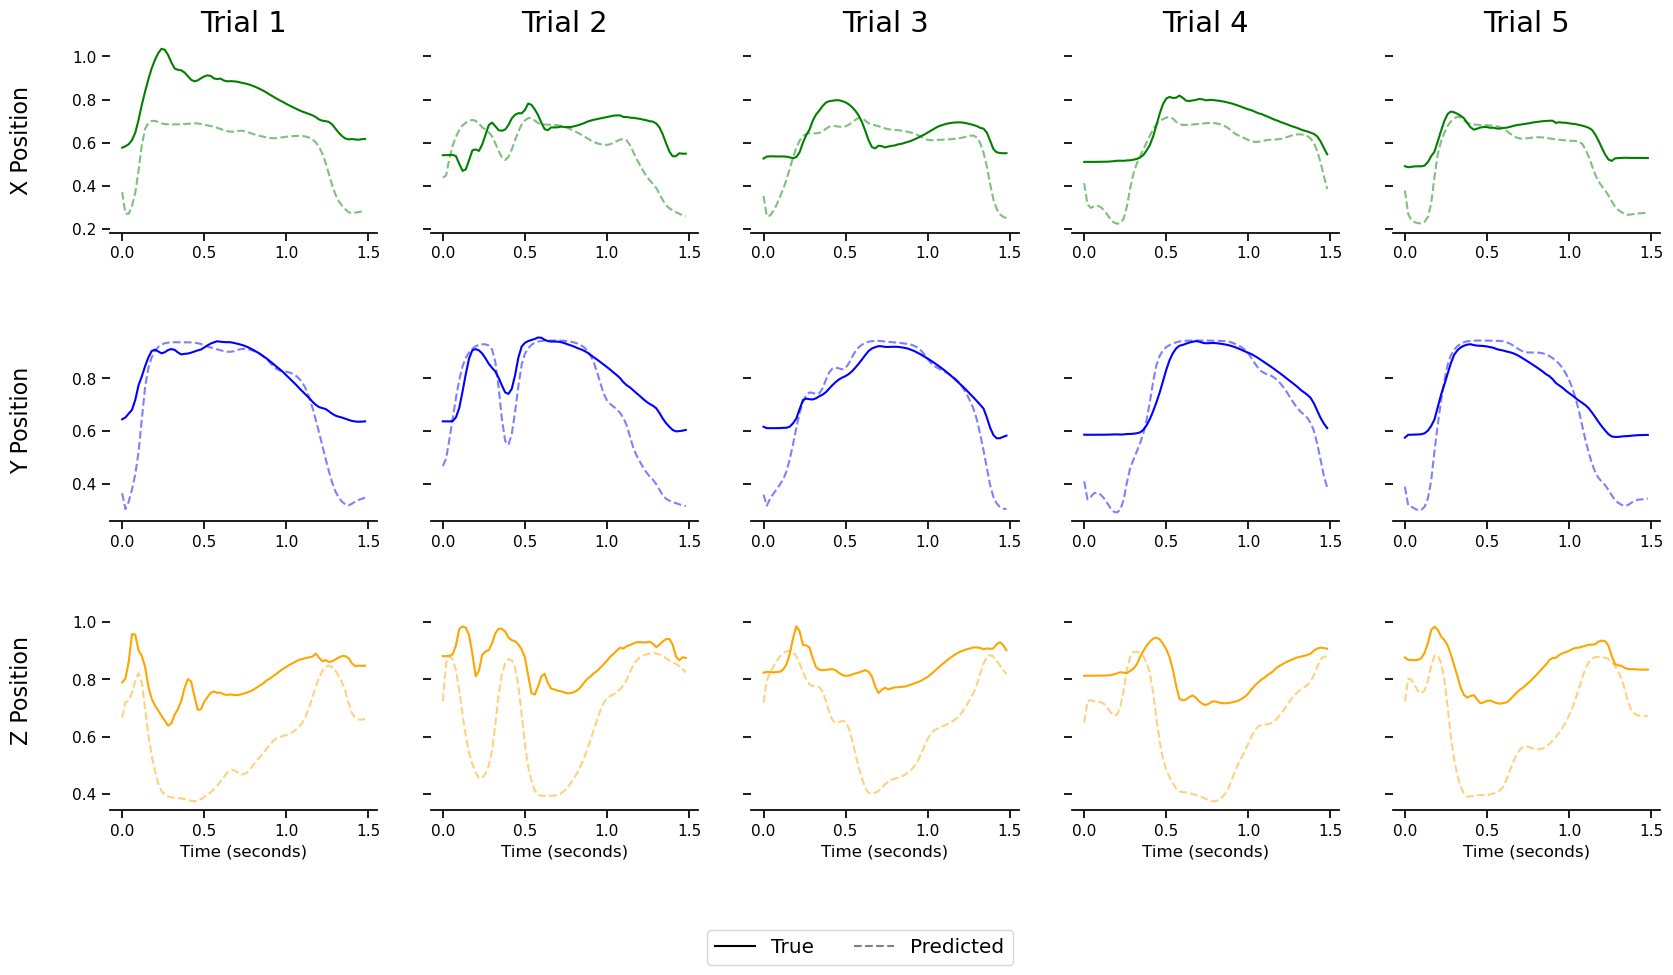

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Training model only on stimulation data and testing on baseline data

In [ ]:
# Fit the LSTM model
model_stim = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= n_hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size_LSTM,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)

model_stim.apply(weight_reset)

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
train_losses, val_losses = \
    train_model(model_stim, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0290 Val 0.0266
Epoch 001 Train 0.0268 Val 0.0237
Epoch 002 Train 0.0226 Val 0.0194
Epoch 003 Train 0.0186 Val 0.0159
Epoch 004 Train 0.0152 Val 0.0132
Epoch 005 Train 0.0127 Val 0.0113
Epoch 006 Train 0.0112 Val 0.0103
Epoch 007 Train 0.0102 Val 0.0097
Epoch 008 Train 0.0094 Val 0.0092
Epoch 009 Train 0.0087 Val 0.0093
Epoch 010 Train 0.0083 Val 0.0089
Epoch 011 Train 0.0078 Val 0.0087
Epoch 012 Train 0.0075 Val 0.0086
Epoch 013 Train 0.0072 Val 0.0084
Epoch 014 Train 0.0069 Val 0.0082
Epoch 015 Train 0.0066 Val 0.0080
Epoch 016 Train 0.0064 Val 0.0080
Epoch 017 Train 0.0062 Val 0.0078
Epoch 018 Train 0.0060 Val 0.0077
Epoch 019 Train 0.0058 Val 0.0079
Epoch 020 Train 0.0056 Val 0.0076
Epoch 021 Train 0.0055 Val 0.0076
Epoch 022 Train 0.0053 Val 0.0074
Epoch 023 Train 0.0052 Val 0.0074
Epoch 024 Train 0.0050 Val 0.0073
Epoch 025 Train 0.0049 Val 0.0072
Epoch 026 Train 0.0048 Val 0.0072
Epoch 027 Train 0.0047 Val 0.0071
Epoch 028 Train 0.0046 Val 0.0070
Epoch 029 Trai

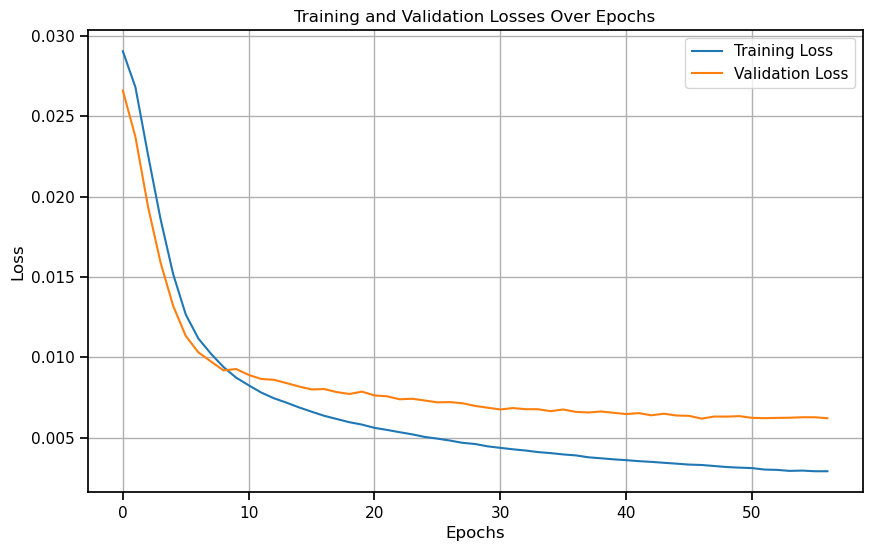

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
experiment_name = 'LSTM_2018_'+name+'_'+date+'_Stimulation'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_stim, path_to_save_model_fold)
# dict_loss = {}
# dict_loss['train'] = train_losses
# dict_loss['val'] = val_losses
# path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
# with open(path_to_save_model_losses, 'wb') as handle:
#     pickle.dump(dict_loss, handle, protocol=4)


In [ ]:
model_stim_trained = torch.load(path_to_save_model_fold)
model_stim_trained.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_stim_trained, metric = 'ev')

Train EV: 0.90 
Val EV: 0.70 
Test EV: 0.72 


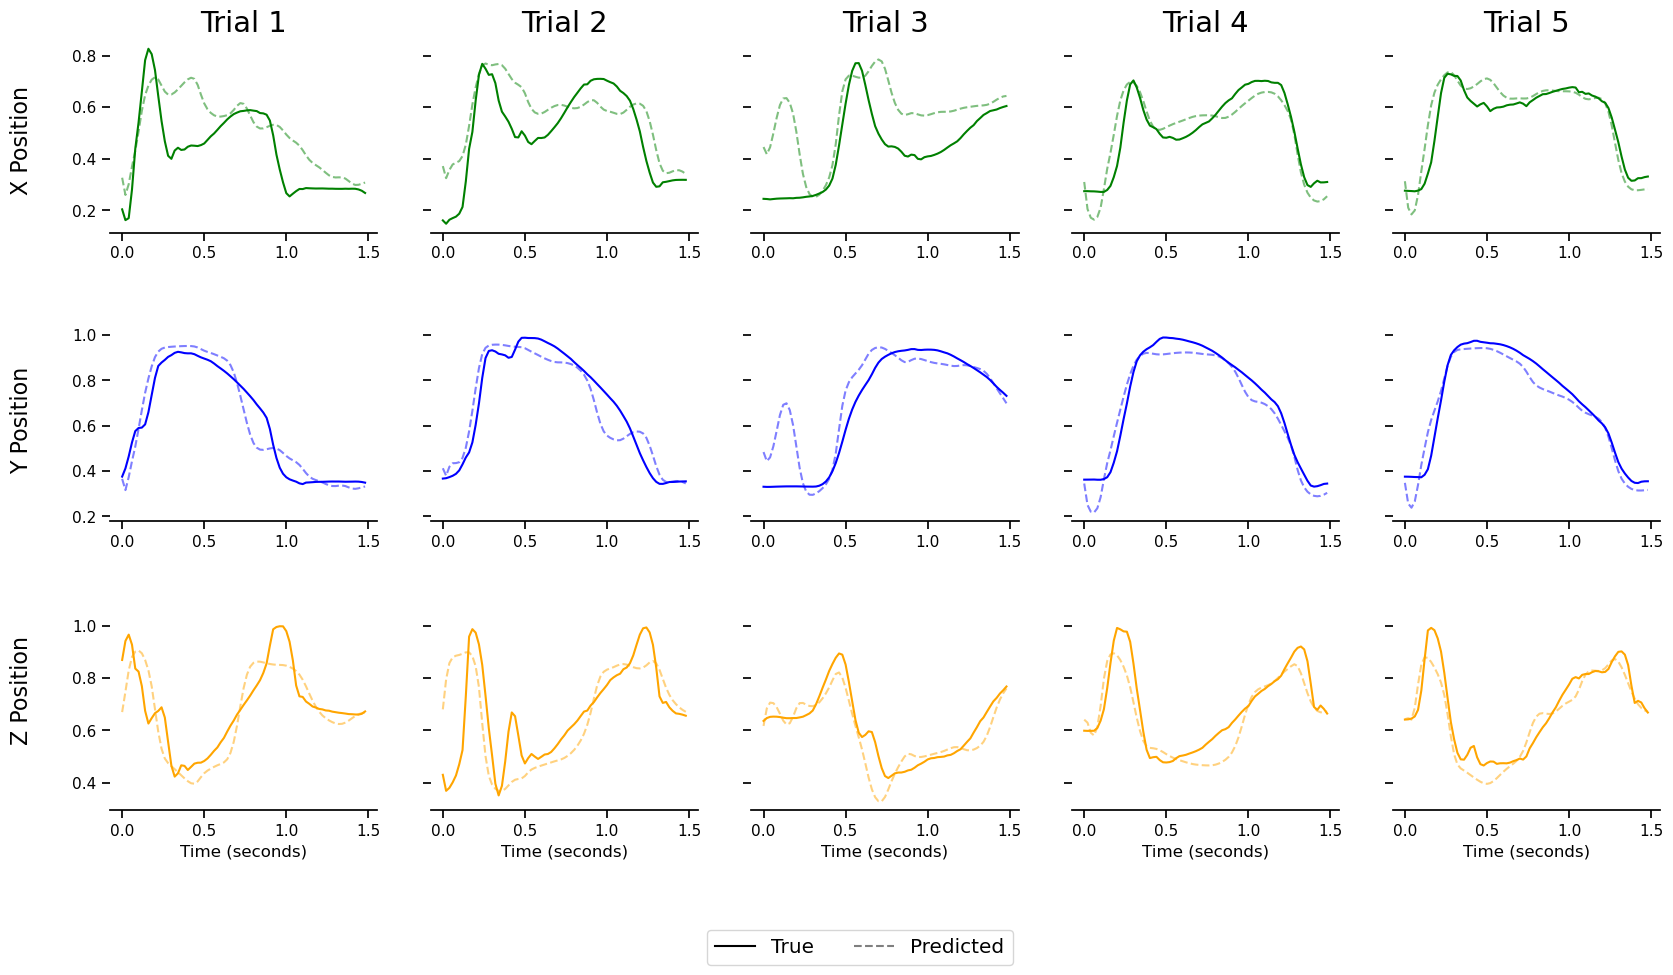

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

### Now test on baseline data to compare to the EWC

In [ ]:
model_stim_trained.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_stim_trained, metric = 'ev')

Train EV: -0.23 
Val EV: -0.70 
Test EV: -0.46 


/home/nerea/CL_UpperLimb_Control/src/trainer.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


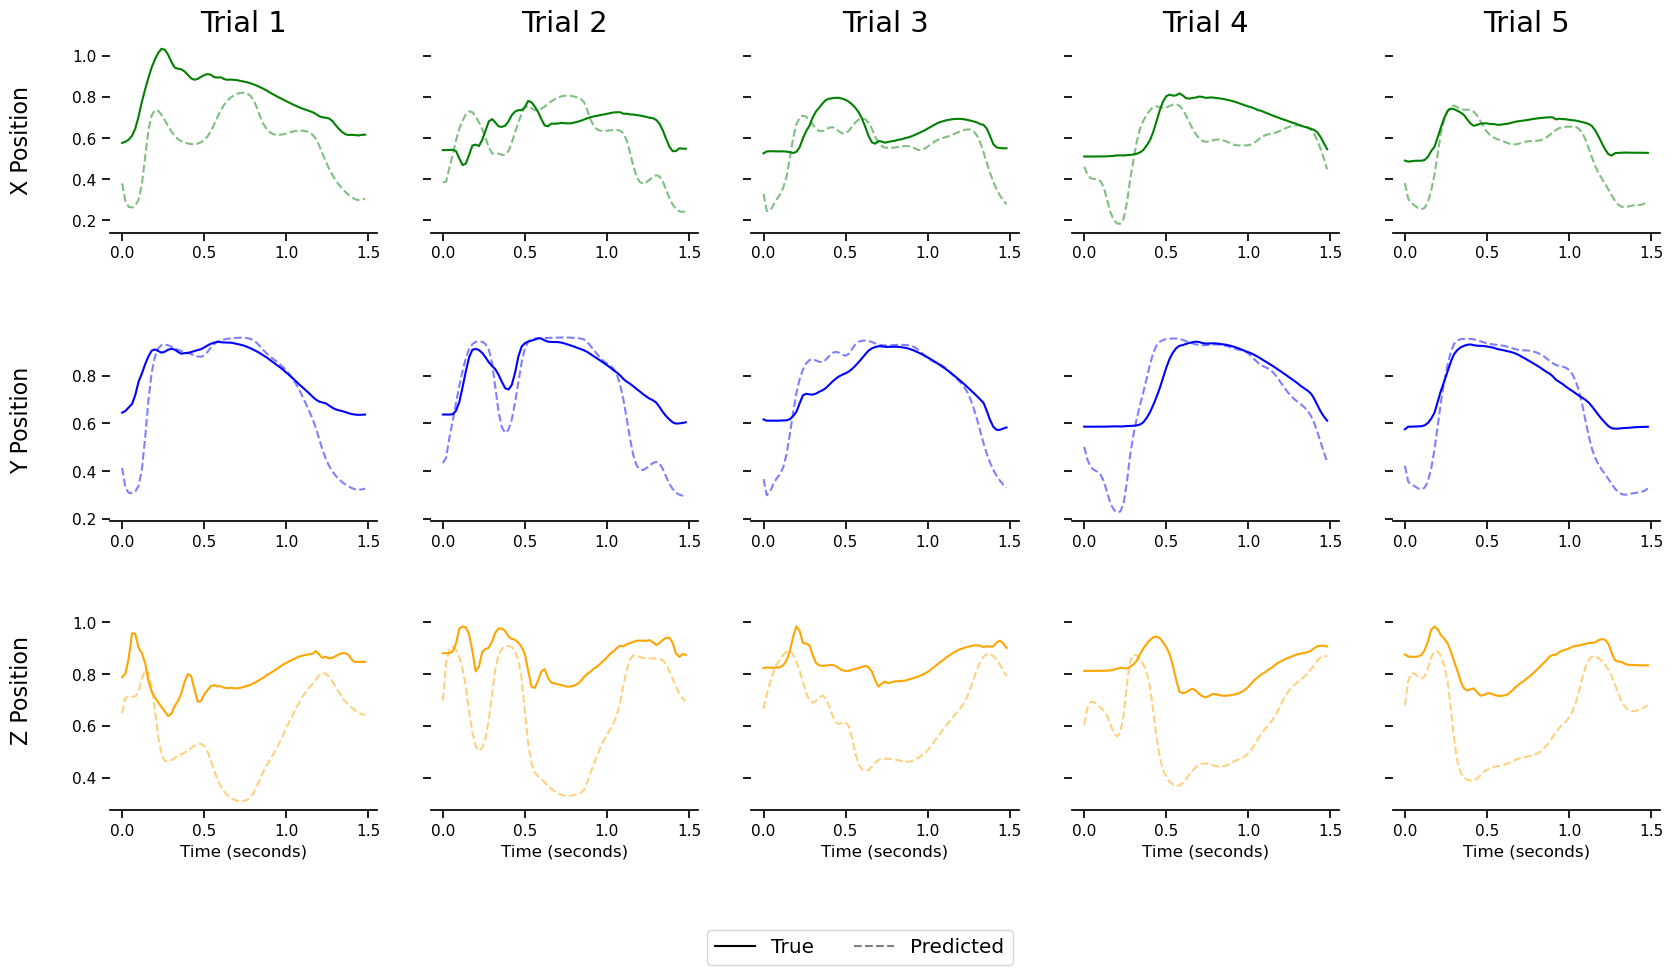

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Checking Catastrophic Forgetting

The idea here is to take models trained for one specific task, train them on the other task and then see how they generalize or not.

In [ ]:
model_stim_after_base  = copy.deepcopy(model_baselineonly)

# Flatten the parameters of the copied model
for module in model_stim_after_base.modules():
    if isinstance(module, nn.RNNBase):
        module.flatten_parameters()
model_stim_after_base.train()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
model_base_after_stim = copy.deepcopy(model_stim_trained)

# Flatten the parameters of the copied model
for module in model_base_after_stim.modules():
    if isinstance(module, nn.RNNBase):
        module.flatten_parameters()
model_base_after_stim.train()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

#### Training on stimulation data using baseline model

In [ ]:
train_losses, val_losses = \
    train_model(model_stim_after_base, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0219 Val 0.0177
Epoch 001 Train 0.0163 Val 0.0139
Epoch 002 Train 0.0136 Val 0.0121
Epoch 003 Train 0.0121 Val 0.0110
Epoch 004 Train 0.0111 Val 0.0104
Epoch 005 Train 0.0104 Val 0.0099
Epoch 006 Train 0.0099 Val 0.0096
Epoch 007 Train 0.0094 Val 0.0094
Epoch 008 Train 0.0089 Val 0.0092
Epoch 009 Train 0.0085 Val 0.0090
Epoch 010 Train 0.0082 Val 0.0090
Epoch 011 Train 0.0079 Val 0.0089
Epoch 012 Train 0.0077 Val 0.0089
Epoch 013 Train 0.0074 Val 0.0088
Epoch 014 Train 0.0072 Val 0.0086
Epoch 015 Train 0.0069 Val 0.0086
Epoch 016 Train 0.0068 Val 0.0085
Epoch 017 Train 0.0066 Val 0.0084
Epoch 018 Train 0.0064 Val 0.0084
Epoch 019 Train 0.0063 Val 0.0084
Epoch 020 Train 0.0062 Val 0.0083
Epoch 021 Train 0.0060 Val 0.0084
Epoch 022 Train 0.0059 Val 0.0081
Epoch 023 Train 0.0059 Val 0.0082
Epoch 024 Train 0.0057 Val 0.0082
Epoch 025 Train 0.0056 Val 0.0081
Epoch 026 Train 0.0056 Val 0.0080
Epoch 027 Train 0.0055 Val 0.0081
Epoch 028 Train 0.0054 Val 0.0080
Epoch 029 Trai

In [ ]:
experiment_name = 'LSTM_2018_'+name+'_'+date+'_Stimulation_after_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_stim_after_base, path_to_save_model_fold)

In [ ]:
model_stim_after_base = torch.load(path_to_save_model_fold)
model_stim_after_base.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_stim_after_base, metric = 'ev')

Train EV: -0.16 
Val EV: -0.47 
Test EV: -0.20 


/home/nerea/CL_UpperLimb_Control/src/trainer.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_stim_after_base, metric = 'ev')

Train EV: 0.85 
Val EV: 0.64 
Test EV: 0.74 


#### Training on baseline data using stimulation model

In [ ]:
train_losses, val_losses = \
    train_model(model_base_after_stim, xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

/home/nerea/CL_UpperLimb_Control/src/trainer.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


Epoch 000 Train 0.0215 Val 0.0072
Epoch 001 Train 0.0155 Val 0.0048
Epoch 002 Train 0.0143 Val 0.0041
Epoch 003 Train 0.0139 Val 0.0038
Epoch 004 Train 0.0136 Val 0.0036
Epoch 005 Train 0.0133 Val 0.0034
Epoch 006 Train 0.0130 Val 0.0032
Epoch 007 Train 0.0126 Val 0.0031
Epoch 008 Train 0.0124 Val 0.0029
Epoch 009 Train 0.0121 Val 0.0028
Epoch 010 Train 0.0117 Val 0.0028
Epoch 011 Train 0.0114 Val 0.0027
Epoch 012 Train 0.0110 Val 0.0026
Epoch 013 Train 0.0107 Val 0.0026
Epoch 014 Train 0.0103 Val 0.0026
Epoch 015 Train 0.0100 Val 0.0026
Epoch 016 Train 0.0096 Val 0.0026
Epoch 017 Train 0.0091 Val 0.0026
Epoch 018 Train 0.0087 Val 0.0026
Epoch 019 Train 0.0084 Val 0.0027
Decrease LR
Epoch 020 Train 0.0080 Val 0.0028
Epoch 021 Train 0.0076 Val 0.0029
Epoch 022 Train 0.0075 Val 0.0030
Epoch 023 Train 0.0072 Val 0.0031
Epoch 024 Train 0.0070 Val 0.0035
Decrease LR
15


In [ ]:
experiment_name = 'LSTM_2018_'+name+'_'+date+'_Baseline_after_Stimulation'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_base_after_stim, path_to_save_model_fold)

In [ ]:
model_base_after_stim = torch.load(path_to_save_model_fold)
model_base_after_stim.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_base_after_stim, metric = 'ev')

Train EV: 0.65 
Val EV: 0.51 
Test EV: 0.54 


In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_base_after_stim, metric = 'ev')

Train EV: 0.46 
Val EV: 0.55 
Test EV: 0.21 


/home/nerea/CL_UpperLimb_Control/src/trainer.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)
